# Определение стоимости автомобилей

**Цель проекта**: построение модели для определения стоимости автомобилей с пробегом.  

**Требования заказчика**:
- качество предсказания;
- скорость предсказания;
- время обучения.

В качестве метрики качества для выбора моделей будет использован RMSE.

Для построения модели используется выборка следующих ретроспективных данных:
-	DateCrawled — дата скачивания анкеты из базы
-	VehicleType — тип автомобильного кузова
-	RegistrationYear — год регистрации автомобиля
-	Gearbox — тип коробки передач
-	Power — мощность (л. с.)
-	Model — модель автомобиля
-	Kilometer — пробег (км)
-	RegistrationMonth — месяц регистрации автомобиля
-	FuelType — тип топлива
-	Brand — марка автомобиля
-	NotRepaired — была машина в ремонте или нет
-	DateCreated — дата создания анкеты
-	NumberOfPictures — количество фотографий автомобиля
-	PostalCode — почтовый индекс владельца анкеты (пользователя)
-	LastSeen — дата последней активности пользователя


**Основные этапы проекта**:
- Подготовка данных
    - анализ и обработка аномалий
    - обработка пропусков
    - коррелляционный анализ количественных переменных
    - кодирование качественных переменных
- Построение моделей
    - случайный лес
    - линейная регрессия
    - стохастический градиентный бустинг
- Тестирование полученных моделей, анализ скорости работы моделей

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import lightgbm as ltb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных 16 столбцов, 3 из которых содержат дату, 6 - качественные данные, 7 (включая целевой) - численные. В данных есть как пропуски, так и аномальные значения.

Проверим датасет на наличие явных дубликатов:

Поскольку данные с датой создания, скачивания и последнего просмотра анкеты не оказывают влияния на оценку стоимости автомобиля для будущих клиентов, удалим их:

In [5]:
data.duplicated().sum()

4

In [6]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [7]:
data = data.drop(columns = ['DateCrawled', 'LastSeen', 'DateCreated'])

### Обработка аномальных значений
Первое, что бросается в глаза - столбец с количеством фотографий **`NumberOfPictures`** содержит только нули, он неинформативен - удалим его:

In [8]:
data = data.drop(['NumberOfPictures'], axis = 1)

Целевой столбец **`Price`** содержит нулевые значения. Посмотрим, много ли в нашем датасете аномально низких цен (менее 5 евро):

In [9]:
data.query('Price < 5')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,19348
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,56412
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,53721
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,40589
111,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,21698
...,...,...,...,...,...,...,...,...,...,...,...,...
354201,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,23758
354234,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,33659
354244,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,42329
354273,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,22559


11 982 строк, или 3% от выборки. Судя по всему, это или ошибка выгрузки, или некорректное заполнение анкеты. Поскольку цена - целевой признак, восстанавливать его по аналогии с похожими строками будет некорректным, удалим позиции со слишком низкими ценами (менее 5 евро).

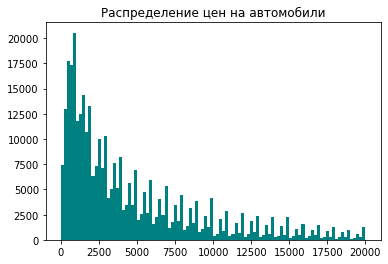

In [10]:
data = data.query('Price > 5')
plt.hist(data['Price'], bins = 100, color = 'teal')
plt.title('Распределение цен на автомобили')
plt.show()

Как видно из графика, значений около 0 всё ещё много, но это могут быть реально выставленные цены на очень старые или битые авто. Распределение сильно скошено влево: основная масса автомобилей выставляется по цене 1000 до 6500 евро, однако есть и очень дорогие предложения: до 20 000 евро. 

В столбце с датой постановки на учёт **`RegistrationYear`** также есть аномальные значения: 1000 или 9999 год. Проанализируем, много ли авто, зарегистрированных после 2016 (дата выгрузки наших данных) и до 1980 года:

In [11]:
data.query('RegistrationYear > 2016')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
22,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,49716
26,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,31139
48,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,48499
51,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,66115
57,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,33397
...,...,...,...,...,...,...,...,...,...,...,...,...
354108,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,32339
354136,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,38315
354199,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,44866
354249,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,45527


In [12]:
data.query('RegistrationYear < 1980')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,24148
360,10000,bus,1976,NaN,0,transporter,5000,0,petrol,volkswagen,NaN,73479
534,4900,convertible,1973,manual,44,kaefer,90000,4,petrol,volkswagen,no,16567
630,12000,sedan,1969,manual,140,s_klasse,80000,3,petrol,mercedes_benz,no,46286
650,15000,coupe,1971,NaN,0,NaN,5000,4,NaN,sonstige_autos,no,51145
...,...,...,...,...,...,...,...,...,...,...,...,...
353908,800,NaN,1970,NaN,0,other,150000,0,NaN,trabant,NaN,1609
353957,200,NaN,1910,NaN,0,NaN,5000,0,petrol,sonstige_autos,NaN,42289
354033,10500,convertible,1968,manual,54,other,20000,4,NaN,renault,no,63755
354282,16500,coupe,1973,manual,200,other,150000,6,petrol,bmw,yes,74722


С автомобилями из "будущего" всё понятно - такие строки придётся удалить, поскольку это явные ошибки выгрузки или ввода, достоверно восстановить эти данные не получится, а возраст авто имеет очевидное влияние на его цену. Можно было бы предположить, что это опечатки, и авто все новые - 2016 года, но по выборке видно, что у них большой пробег, так что реальный год регистрации не угадаешь.

С "ретроавтомобилями" не всё так очевидно, вероятно, в эту выборку могли попасть и правда ретроэкзепляры, но рынок таких автомобилей характеризуется особым ценообразованием, каждый экземпляр рассматривается уже не с точки зрения формальных характеристик, а с учётом сохранности, ухоженности и "истории". Есть и очевидные ошибки - например, Fiat 500, якобы поставленный на учёт в 1971 г., тогда как выпуск этой модели начался в 2007.

Количество таких авто почти 5%, удалим их из рассмотрения:

In [13]:
data = data.query('2016 >= RegistrationYear >= 1980')

В столбце **`Power`** с данными о мощности автомобиля явно аномальные значения - менее 10 л.с. или больше 1600.

In [14]:
print('Доля аномальных значений в столбце Power:', round(data.query('Power < 10 | Power > 1600')['Power'].count() / len(data) * 100, 1), '%')

Доля аномальных значений в столбце Power: 9.8 %


Посмотрим на графики распределения мощности в нашей выборке и зависимости цены от мощности:

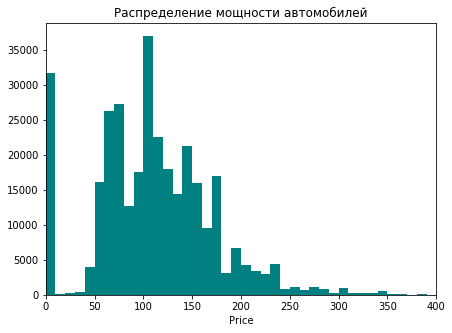

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
data['Power'].hist(bins = 2000, grid = False, color = 'teal')
plt.title('Распределение мощности автомобилей')
plt.xlabel('Price')
ax.set_xlim([0, 400])
plt.show()

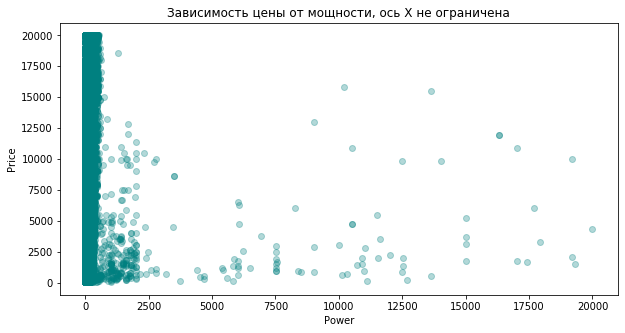

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data['Power'], data['Price'], alpha = 0.3, color = 'teal')
plt.title('Зависимость цены от мощности, ось X не ограничена')
plt.xlabel('Power')
plt.ylabel('Price')
plt.show()

По графику видно, что в основном цена на самые "мощные" экземпляры находится в нижнем диапазоне, что также говорит об ошибках в анкетах.

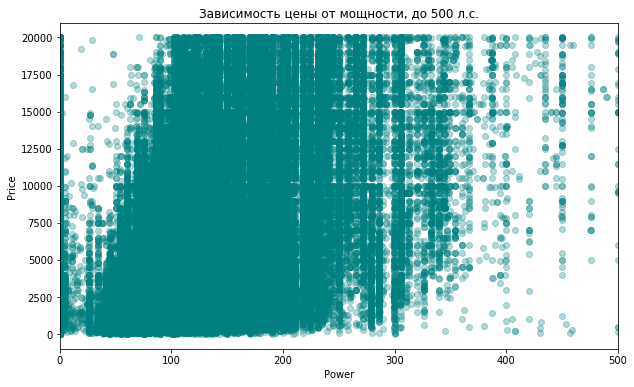

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Power'], data['Price'], alpha = 0.3, color = 'teal')
ax.set_xlim([0, 500])
plt.title('Зависимость цены от мощности, до 500 л.с.')
plt.xlabel('Power')
plt.ylabel('Price')
plt.show()

Попробуем заменить аномально высокие (границу приняла за 500 л.с.) и низкие значения (менее 50 л.с.) на наиболее частые по аналогичной модели.

In [19]:
data.loc[(data['Power'] < 50) | (data['Power'] > 500), 'Power'] = np.NAN
data['Power'] = data.groupby(['Brand', 'Model'])['Power'].apply(lambda x: x.fillna(x.mode().iat[0]))

Посмотрим на график зависимости после замены аномалий:

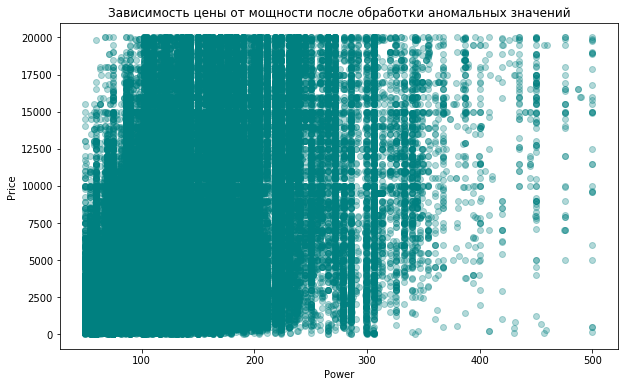

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data['Power'], data['Price'], alpha = 0.3, color = 'teal')
plt.title('Зависимость цены от мощности после обработки аномальных значений')
plt.xlabel('Power')
plt.ylabel('Price')
plt.show()

По графику видно, что у маломощных машин цены находятся в нижнем диапазоне (в основном до 7500 евро), мощные же машины в основном оцениваются выше этого порога. 


Нам осталось проверить, нет ли опечаток и скрытых повторов в названиях **моделей** и **марок автомобилей**:

In [21]:
np.sort(data['Model'].unique().tolist())

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [22]:
data['Brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'alfa_romeo', 'subaru',
       'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia', 'citroen',
       'sonstige_autos', 'toyota', 'chevrolet', 'dacia', 'daihatsu',
       'trabant', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'land_rover', 'lada'], dtype=object)

В названиях марок и моделей скрытых дубликатов не обнаружено.

### Обработка пропусков

Посмотрим на количество пропусков по столбцам в абсолютных значениях и в долях (напомню, в столбце `Power` у нас искусственно созданные NAN, они совпадают с теми строками, в которых пропущено название модели автомобиля): 

In [23]:
display(data.isnull().sum())
print('Пропуски в долях:')
display(round(data[['VehicleType', 'Gearbox', 'Power', 'Model', 'FuelType', 'NotRepaired']].isnull().sum() / len(data), 2))

Price                    0
VehicleType          19288
RegistrationYear         0
Gearbox              14709
Power                14678
Model                14678
Kilometer                0
RegistrationMonth        0
FuelType             23213
Brand                    0
NotRepaired          58407
PostalCode               0
dtype: int64

Пропуски в долях:


VehicleType    0.06
Gearbox        0.05
Power          0.05
Model          0.05
FuelType       0.07
NotRepaired    0.18
dtype: float64

В столбце **`NotRepaired`** (была машина в ремонте или нет) пропусков очень много - 18%, терять такое количество данных не хотелось бы, восстановить достоверно эту информацию по имеющимся данным не получится. Предлагается оставить пропуск как третью категорию для этого признака: авто было в ремонте/не было/данные не указаны. 

In [24]:
data['NotRepaired'] = data['NotRepaired'].fillna('-')

Столбец **`Model`** содержит 5% пропусков, их восстановить также не получится - никак не угадаешь, какую именно из моделей указанной марки владелец выставил на продажу, а для цены этот показатель имеет ключевое значение. Предлагается удалить строки с пропусками в этом признаке.

In [25]:
data.dropna(subset = ['Model'], inplace = True)

# Проверрим, все ли пропуски удалены
display(round(data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].isnull().sum() / len(data), 2))

VehicleType    0.05
Gearbox        0.04
Model          0.00
FuelType       0.06
NotRepaired    0.00
dtype: float64

Следующий столбец с достаточно большим количеством пропусков (6%) - **`VehicleType` (тип кузова)**. Рассмотрим данные в столбце подробнее и попробуем восстановить тип кузова по марке и модели авто.

In [26]:
perc = data['VehicleType'].value_counts(dropna=False)
perc

sedan          85312
small          74510
wagon          61487
bus            27259
convertible    18718
NaN            15825
coupe          14285
suv            10927
other           2532
Name: VehicleType, dtype: int64

In [27]:
data.groupby(['Model', 'Brand'])['VehicleType'].unique()

Model    Brand     
100      audi                    [nan, wagon, sedan, coupe, convertible]
145      alfa_romeo                    [nan, small, sedan, coupe, other]
147      alfa_romeo             [sedan, small, wagon, coupe, nan, other]
156      alfa_romeo             [wagon, sedan, nan, coupe, other, small]
159      alfa_romeo                                  [sedan, wagon, nan]
                                             ...                        
yaris    toyota                   [small, bus, other, nan, wagon, sedan]
yeti     skoda                                  [suv, nan, other, wagon]
ypsilon  lancia                                [small, nan, convertible]
z_reihe  bmw                            [convertible, coupe, nan, sedan]
zafira   opel          [bus, nan, other, wagon, small, suv, sedan, co...
Name: VehicleType, Length: 295, dtype: object

In [28]:
data.pivot_table(index=['Model', 'Brand'], columns='VehicleType', values='Price', aggfunc='count').fillna(0)

,VehicleType,bus,convertible,coupe,other,sedan,small,suv,wagon
Model,Brand,,,,,,,,
100,audi,0.0,1.0,1.0,0.0,248.0,0.0,0.0,103.0
145,alfa_romeo,0.0,0.0,2.0,1.0,12.0,19.0,0.0,0.0
147,alfa_romeo,0.0,0.0,26.0,6.0,358.0,93.0,0.0,2.0
156,alfa_romeo,0.0,0.0,3.0,1.0,267.0,2.0,0.0,281.0
159,alfa_romeo,0.0,0.0,0.0,0.0,55.0,0.0,0.0,144.0
...,...,...,...,...,...,...,...,...,...
yaris,toyota,42.0,0.0,0.0,3.0,27.0,879.0,0.0,7.0
yeti,skoda,0.0,0.0,0.0,2.0,0.0,0.0,168.0,1.0
ypsilon,lancia,0.0,1.0,0.0,0.0,0.0,175.0,0.0,0.0


Мы столкнулись с тем, что одна и та же марка машины может выпускаться в разных типах кузова. Кроме того, сами владельцы могут указывать близкие типы кузова по-разному. Заполним пропуски типом, наиболее часто встречающимся для конкретной марки.  

In [29]:
# создаем столбец с маркером замены NAN
data.loc[data['VehicleType'].isna(), 'Vehicle_nan'] = 1

# замена пропуска на моду по каждой группе:
data['VehicleType'] = data.groupby(['Brand', 'Model'])['VehicleType'].apply(lambda x: x.fillna(x.mode().iat[0]))

Проверим, все ли пропуски заполнены, и в какой пропорции:

In [30]:
data.loc[data['Vehicle_nan'] == 1]['VehicleType'].value_counts(dropna=False)

sedan          6517
small          4816
bus            1837
wagon          1800
coupe           351
suv             337
convertible     155
other            12
Name: VehicleType, dtype: int64

Теперь рассмотрим подробнее пропуски в данных о типе **коробки передач** (столбец **`Gearbox`**):

In [31]:
data.loc[data['Gearbox'].isna()].head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode,Vehicle_nan
16,300,small,2016,NaN,60.0,polo,150000,0,petrol,volkswagen,-,38871,1.0
32,245,sedan,1994,NaN,75.0,golf,150000,2,petrol,volkswagen,no,44145,NaN
37,1500,bus,2016,NaN,75.0,kangoo,150000,1,gasoline,renault,no,46483,1.0
69,1200,coupe,2001,NaN,75.0,astra,150000,0,NaN,opel,-,47249,NaN
92,250,small,2000,NaN,60.0,ka,150000,0,NaN,ford,-,51427,1.0


In [32]:
data['Gearbox'].value_counts(normalize=True, dropna=False)

manual    0.768477
auto      0.191884
NaN       0.039639
Name: Gearbox, dtype: float64

Одна и та же модель автомобиля, как правило, выпускается в различных комплектациях коробки передач, а её тип существенно влияет на стоимость авто. Можно было бы заполнить пропуски наиболее частым типом - ручной коробкой, однако тем самым можно ухудшить работу моделей. Поскольку пропусков в этом столбце немного - 4%, предлагается их удалить. 

In [33]:
data.dropna(subset = ['Gearbox'], inplace = True)

display(round(data[['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']].isnull().sum() / len(data), 2))

VehicleType    0.00
Gearbox        0.00
Model          0.00
FuelType       0.05
NotRepaired    0.00
dtype: float64

У нас остался только столбец с **типом топлива (`FuelType`)**, в котором 5% пропусков. Посмотрим, какие типы в нём встречаются:

In [34]:
data['FuelType'].value_counts(normalize=True, dropna=False)

petrol      0.634436
gasoline    0.298784
NaN         0.048554
lpg         0.015435
cng         0.001668
hybrid      0.000650
other       0.000278
electric    0.000194
Name: FuelType, dtype: float64

In [35]:
data.pivot_table(index=['Model', 'Brand'], columns='FuelType', values='Price', aggfunc='count').fillna(0)

,FuelType,cng,electric,gasoline,hybrid,lpg,other,petrol
Model,Brand,,,,,,,
100,audi,0.0,0.0,14.0,0.0,8.0,0.0,315.0
145,alfa_romeo,0.0,0.0,0.0,0.0,0.0,0.0,36.0
147,alfa_romeo,0.0,0.0,126.0,0.0,13.0,0.0,358.0
156,alfa_romeo,0.0,0.0,176.0,0.0,15.0,0.0,333.0
159,alfa_romeo,0.0,0.0,138.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...
yaris,toyota,0.0,0.0,93.0,18.0,0.0,0.0,826.0
yeti,skoda,0.0,0.0,83.0,0.0,0.0,0.0,86.0
ypsilon,lancia,0.0,0.0,6.0,0.0,1.0,0.0,162.0


Аналогично типу кузова и коробке передач, тип топлива может отличаться от одной и той же марки. Заполним пропуски типом топлива, наиболее часто встречающимся для каждой конкретной марки автомобиля:

In [36]:
# создаем столбец с маркером замены NAN
data.loc[data['FuelType'].isna(), 'Fuel_nan'] = 1

# замена пропуска на моду по каждой группе:
data['FuelType'] = data.groupby(['Model','Brand'])['FuelType'].apply(lambda x: x.fillna(x.mode().iat[0]))

Проверим, все ли пропуски заполнены, и в какой пропорции:

In [37]:
data.loc[data['Fuel_nan'] == 1]['FuelType'].value_counts(dropna=False)

petrol      11668
gasoline     2827
Name: FuelType, dtype: int64

Посмотрим на структуру нашего датасета после обработки аномалий и пропусков:

In [38]:
data = data.drop(columns = ['Vehicle_nan', 'Fuel_nan'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298533 entries, 0 to 354364
Data columns (total 12 columns):
Price                298533 non-null int64
VehicleType          298533 non-null object
RegistrationYear     298533 non-null int64
Gearbox              298533 non-null object
Power                298533 non-null float64
Model                298533 non-null object
Kilometer            298533 non-null int64
RegistrationMonth    298533 non-null int64
FuelType             298533 non-null object
Brand                298533 non-null object
NotRepaired          298533 non-null object
PostalCode           298533 non-null int64
dtypes: float64(1), int64(5), object(6)
memory usage: 29.6+ MB


In [39]:
round(len(data) / 354369 * 100, 1)

84.2

После удаления аномальных и пропущенных значений у нас осталось 84% данных.

### Корреляционный анализ

Проанализируем связь между количественными переменными:

In [40]:
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
Price,1.000000,0.571071,0.513016,-0.386281,0.073674,0.069277
RegistrationYear,0.571071,1.000000,0.130442,-0.362891,0.045157,0.035074
Power,0.513016,0.130442,1.000000,0.097472,0.044041,0.057251
Kilometer,-0.386281,-0.362891,0.097472,1.000000,-0.016269,-0.011647
RegistrationMonth,0.073674,0.045157,0.044041,-0.016269,1.000000,0.005386
PostalCode,0.069277,0.035074,0.057251,-0.011647,0.005386,1.000000


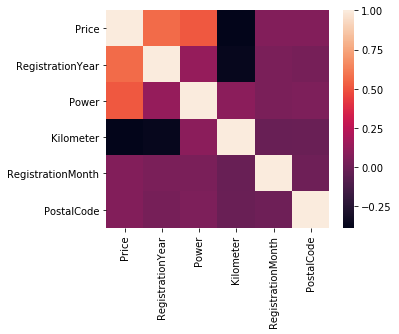

In [41]:
plt.figure(figsize=(5,4))
sns.heatmap(data.corr())
plt.show()

Из количественных показателей на цену автомобиля наибольшее влияние оказывают *год регистрации* (т. е., "возраст") автомобиля, его *мощность* и *пробег*, который сильно коррелирует с *возрастом авто* (пробовала по этой причине исключить его из признаков - качество модели ухудшилось). Меньше всего влияют на ценообразование месяц регистрации и почтовый индекс владельца (также пробовала их исключить, но с ними качество модели лучше).

### Кодирование качественных переменных

Закодируем категориальные признаки (столбцы VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired) с помощью метода One-Hot Encoding:

In [42]:
data_ohe = pd.get_dummies(data, drop_first = True)
data_ohe.head(2)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
0,480,1993,75.0,150000,0,70435,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,9800,2004,163.0,125000,8,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


В результате получили 306 столбцов с влияющими признаками.

### Вывод
В рамках предобрботки выполнено следующее:
- удалены из рассмотрения столбцы с датой заполнения, выгрузки, последнего просмотра анкеты, данные о количестве фотографий;
- удалены позиции с аномальными значениями о дате регистрации автомобиля;
- аномальные значения в столбце с мощностью автомобиля заменены на модальные значения по марке авто;
- удалены пропуски в целевом столбце с ценой, столбцах с моделью автомобиля и типом коробки передач;
- пропуски в столбцах с типом кузова, типом топлива заменены на модальные по аналогичной марке автомобиля;
- произведён коррелляционный анализ между переменными;
- качественные переменные закодированы с помощью метода OHE.

В результате нам пришлось удалить около 16% исходных данных, теперь датасет содержит 298533 наблюдений, 1 целевой признак и 306 влияющих.

## Обучение моделей

Разобъём данные на **тестовую и обучающую** выборки в соотношении 25/75:

In [43]:
target = data_ohe['Price']
features = data_ohe.drop('Price', axis = 1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.25, 
                                                                           random_state = 1)
print('Размер тренировочной выборки:', target_train.shape)
print('Размер тестовой выборки:', target_test.shape)

Размер тренировочной выборки: (223899,)
Размер тестовой выборки: (74634,)


Произведём **масштабирование** количественных данных:

In [44]:
pd.options.mode.chained_assignment = None
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head(3))
display(features_test.head(3))

,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
191026,-0.511729,-1.226589,0.58203,1.116511,-0.120494,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
210314,-0.850772,0.568509,0.58203,-1.104883,-0.205072,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
327479,-0.003164,-1.188396,0.58203,1.116511,0.209122,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no,NotRepaired_yes
222797,-1.698381,-0.577299,0.58203,-0.827209,-1.460036,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
120718,0.166358,-0.978331,0.58203,-0.827209,-1.512669,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
305410,-1.020294,-1.150202,0.58203,1.394185,1.098061,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


Обучим и исследуем следующие модели: 
- случайный лес
- линейная регрессия
- стохастический градиентный бустинг

---
Начнём со **случайного леса**:

In [45]:
def RMSE (target, predictions): 
    return round(mean_squared_error(target, predictions)**0.5, 0)
rmse_score = make_scorer(RMSE, greater_is_better = False)

In [46]:
%%time
forest = RandomForestRegressor(random_state=1)
params = {'max_depth':range(1,5),
          'n_estimators': range(10,50,10)}
random_forest = RandomizedSearchCV(forest, params, random_state=1, 
                                   scoring = rmse_score, cv = 5)
random_forest.fit(features_train, target_train)
print('Параметры лучшего случайного леса', random_forest.best_params_)
print('Лучшая модель случайного леса показала RMSE', round(-random_forest.best_score_))

Параметры лучшего случайного леса {'n_estimators': 30, 'max_depth': 4}
Лучшая модель случайного леса показала RMSE 2481
CPU times: user 14min 33s, sys: 12.7 s, total: 14min 46s
Wall time: 14min 58s


---
Модель **линейной регрессии**:

In [47]:
%%time
linear = LinearRegression()
linear.fit(features_train, target_train)
predictions = linear.predict(features_train)
linear_scores = cross_val_score(linear, features_train, target_train, scoring = rmse_score, cv = 5)
print('Средняя оценка RMSE модели линейной регрессии:', - round(linear_scores.mean()))

Средняя оценка RMSE модели линейной регрессии: 2455
CPU times: user 1min 41s, sys: 29.3 s, total: 2min 10s
Wall time: 2min 11s


---
Стохастический **градиентный бустинг**. 
Сперва построим дефолтную модель, без изменения гиперпараметров:

In [48]:
%%time
boost = ltb.LGBMRegressor(random_state = 1, metric = 'rmse')
boost.fit(features_train, target_train)
predictions = boost.predict(features_train)

boost_scores = cross_val_score(boost, features_train, target_train, scoring = rmse_score, cv = 5)
print('Средняя оценка RMSE модели градиентного бустинга:', - round(boost_scores.mean()))

Средняя оценка RMSE модели градиентного бустинга: 1614
CPU times: user 1min 11s, sys: 2.59 s, total: 1min 14s
Wall time: 1min 16s


Теперь попробуем изменить гиперпараметры модели: увеличить количество деревьев (по умолчанию - 100), ограничить максимальную глубину дерева (по умолчанию не ограничена), изменить скорость обучения (по умолчанию 0,1):

In [49]:
%%time
model = ltb.LGBMRegressor(random_state = 1, metric = 'rmse')
params = {'max_depth':[5,10],
          'n_estimators': [150,200],
          'learning_rate': [0.05,0.1,0.2]}
boost_model = RandomizedSearchCV(model, params, random_state=1, 
                                   scoring = rmse_score, cv = 5)
boost_model.fit(features_train, target_train)
print('Параметры лучшей модели бустинга', boost_model.best_params_)
print('Лучшая модель бустинга показала RMSE', round(-boost_model.best_score_))

Параметры лучшей модели бустинга {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.2}
Лучшая модель бустинга показала RMSE 1535
CPU times: user 12min 42s, sys: 20.1 s, total: 13min 2s
Wall time: 13min 12s


## Анализ моделей

Как видим, модель градиентного бустинга даже с дефолтными параметрами показала ошибку RMSE гораздо лучше, чем модели линейной регрессии и случайного леса. При этом дефолтная модель бустинга обучалась почти в 2 раза быстрее, чем модель линейной регрессии. 
Подбор параметров бустинга позволили ещё немного улучшить метрику RMSE, но при этом время обучения увеличилось более, чем в 10 раз, а метрика изменилась незначительно.

Проверим все модели на тестовой выборке: 

In [50]:
def model_test (model, name):
    test_predictions = model.predict(features_test)
    test_RMSE = round(RMSE(target_test, test_predictions))
    print('RMSE модели ', name, 'на тестовой выборке:', test_RMSE)

In [51]:
%%time
model_test(random_forest, 'случайный лес')

RMSE модели  случайный лес на тестовой выборке: 2459
CPU times: user 175 ms, sys: 61.4 ms, total: 237 ms
Wall time: 283 ms


In [52]:
%%time
model_test(linear, 'линейная регрессия')

RMSE модели  линейная регрессия на тестовой выборке: 2447
CPU times: user 76.9 ms, sys: 81.5 ms, total: 158 ms
Wall time: 166 ms


In [53]:
%%time
model_test(boost, 'градиентный бустинг (дефолтная)')

RMSE модели  градиентный бустинг (дефолтная) на тестовой выборке: 1611
CPU times: user 1.21 s, sys: 122 ms, total: 1.33 s
Wall time: 1.32 s


In [54]:
%%time
model_test(boost_model, 'градиентный бустинг (с подбором параметров)')

RMSE модели  градиентный бустинг (с подбором параметров) на тестовой выборке: 1536
CPU times: user 1.9 s, sys: 109 ms, total: 2 s
Wall time: 1.99 s


Сравним качество наших моделей с качеством константной модели, заполненной медианными значениями:

In [55]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy_predictions = dummy_regr.predict(features_test)
dummy_rmse = RMSE(target_test, dummy_predictions)
print('Константная модель показывает RMSE', dummy_rmse)

Константная модель показывает RMSE 4559.0


Несмотря на то, что ошибка RMSE у наших моделей достаточно высокая (относительно медианных значений целевого признака), все модели показывают результат гораздо лучше константной. Высокие показатели RMSE можно объяснить большим размахом цен на автомобили в анализируемом датасете. 

Объединим полученные результаты по всем моделям:

In [57]:
result_table = pd.DataFrame([[-random_forest.best_score_, -linear_scores.mean(), -boost_scores.mean(), 
                              -boost_model.best_score_],
                            [2459, 2447, 1611, 1536],
                            [15, 2, 1, 13],
                            [0.3, 0.12, 1.3, 2]],
                            columns = ['Random forest', 'Linear regression', 'LGBMR (default)', 'LGBMR'],
                            index = ['RMSE на обучении', 'RMSE на тесте', 'Время обучения, мин.', 'Скорость предсказания, сек.'])
round(result_table, 1)                           

,Random forest,Linear regression,LGBMR (default),LGBMR
RMSE на обучении,2480.6,2455.0,1613.8,1534.8
RMSE на тесте,2459.0,2447.0,1611.0,1536.0
"Время обучения, мин.",15.0,2.0,1.0,13.0
"Скорость предсказания, сек.",0.3,0.1,1.3,2.0


Проанализируем результаты работы лучшей модели (дефолтный градиентный бустинг) с точки зрения влияния переменных на целевой признак:

In [125]:
importances = pd.Series(boost.feature_importances_, index = features_test.columns).sort_values(ascending = False)

# исходные названия признаков:
features = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode', 
           'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# суммируем значения для каждого качественного признака:
importances['VehicleType'] = importances[importances.index.str.contains(r"^VehicleType")].sum()
importances['Gearbox'] = importances[importances.index.str.contains(r"^Gearbox")].sum()
importances['Model'] = importances[importances.index.str.contains(r"^Model")].sum()
importances['FuelType'] = importances[importances.index.str.contains(r"^FuelType")].sum()
importances['Brand'] = importances[importances.index.str.contains(r"^Brand")].sum()
importances['NotRepaired'] = importances[importances.index.str.contains(r"^NotRepaired")].sum()

importances = importances[features].sort_values(ascending = False)
importances

Model                658
Brand                592
RegistrationYear     549
Power                479
VehicleType          218
Kilometer            204
NotRepaired           86
PostalCode            86
FuelType              68
RegistrationMonth     31
Gearbox               29
dtype: int64

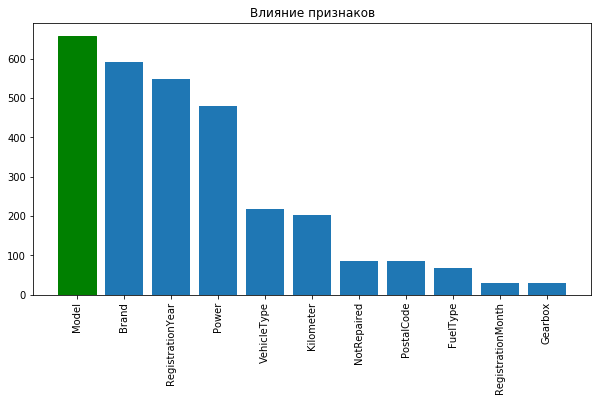

In [122]:
plt.figure(figsize=(10, 5))
bar = plt.bar(importances.index, importances)
bar[0].set_color('g')
plt.title('Влияние признаков')
plt.xticks(rotation = 90)
plt.show()

Как видим, наибольшее влияние на формирование цены оказывает марка и модель машины и её возраст. Затем идут мощность, тип кузова и прочие характеристики. Удивляет, что факт ремонта оказывает небольшое влияние, а коробка передач оказалась наименее важной характеристикой в модели - даже менее важной, чем месяц регистрации. 

## Вывод
Заказчиком была поставлена задача разработки модели для предсказания стоимости автомобилей с пробегом по характеристикам, указанным продавцом в анкете. Критерии выбора модели: качество и скорость работы. В качестве оценки качества применялась метрика RMSE.

В рамках проекта было обучено 4 модели:
- случайный лес
- линейная регрессия
- стохастический градиентный бустинг с дефолтными параметрами
- стохастический градиентный бустинг с подбором гиперпараметров

С точки зрения соотношения времени обучения и качества лучшие результаты показала **дефолтная модель градиентного бустинга**: RMSE на тестовой выборке 1653, время обучения - около 1 минуты. Подбор гиперпараметров для модели бустинга позволяет улучшить метрику RMSE на 5%, но скорость обучения модели падает более чем в десять раз по сравнению с дефолтной моделью. 
С точки зрения скорости предсказания разница во времени не существенна, поскольку все модели работают в пределах 3 секунд. 

**Поскольку в данном проекте для заказчика важны и качество, и скорость работы модели, рекомендуется использовать для предсказания дефолтную модель градиентного бустинга.**